In [1]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "data/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = 'data/kodak-small'
input_size_C = (64,64,3)
input_size_S = (64,64,6)

### Define functions

In [10]:
def load_dataset_small(num_images_per_class_train=15):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.
        
    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    for c in os.listdir(TEST_DIR):
        img = image.load_img(os.path.join(TEST_DIR, c))
        x = image.img_to_array(img)
        X_test.append(x)
    random.shuffle(X_test)
    
    X_train = np.array(X_train)/255.
    X_test = np.array(X_test)/255.
    # Return train and test data as numpy arrays.
    return X_train, X_test

# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 2.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    s_true_1 = s_true[...,0:3]
    s_true_2 = s_true[...,3:6]
    s_pred_1 = s_pred[...,0:3]
    s_pred_2 = s_pred[...,3:6]
    
    return beta * K.sum(K.square(s_true_1 - s_pred_1) + K.square(s_true_2 - s_pred_2))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:6], y_true[...,6:9]
    s_pred, c_pred = y_pred[...,0:6], y_pred[...,6:9]
    
    c_loss = K.sum(K.square(c_true - c_pred))
    s_loss = rev_loss(s_true, s_pred)
    
    
    return  c_loss + s_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder():
    input_S = Input(shape=(input_size_S))
    input_C= Input(shape=(input_size_C))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size_C))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid6_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid7_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(6, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model():
    input_S = Input(shape=(input_size_S))
    input_C= Input(shape=(input_size_C))
    
    encoder = make_encoder()
    
    decoder = make_decoder()
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003
    
def train(input_S, input_C, NB_EPOCHS=1000, BATCH_SIZE =32):

    m = input_S.shape[0]
    loss_history = []
    log = tqdm_notebook(range(NB_EPOCHS),ncols=800)
    for epoch in log:
        np.random.shuffle(input_S)
        np.random.shuffle(input_C)

        t = range(0, input_S.shape[0], BATCH_SIZE)
        ae_loss = []
        rev_loss = []
        for idx in t:

            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

            C_prime = encoder_model.predict([batch_S, batch_C])

            ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                       y=np.concatenate((batch_S, batch_C),axis=3)))
            rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                                  y=batch_S))

            # Update learning rate
            K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
            K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        log.set_description('Epoch {} | Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, np.mean(ae_loss), np.mean(rev_loss)))
        loss_history.append(np.mean(ae_loss))
        # Plot loss through epochs
    plt.plot(loss_history)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

def pixel_errors(input_S_1, input_S_2, input_C, decoded_S_1, decoded_S_2, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S_1pixel = np.sqrt(np.mean(np.square(255*(input_S_1 - decoded_S_1))))
    see_S_2pixel = np.sqrt(np.mean(np.square(255*(input_S_2 - decoded_S_2))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S_1pixel, see_S_2pixel, see_Cpixel

def pixel_histogram(diff_S_1, diff_S_2,  diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat1 = diff_S_1.flatten()
    diff_Sflat2 = diff_S_2.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,3,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,3,2)
    imgplot = plt.hist(255* diff_Sflat1, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the first Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,3,3)
    imgplot = plt.hist(255* diff_Sflat2, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the second Secret image.')
    plt.axis([0, 250, 0, 0.2])
    plt.show()
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)
        
        
# Configs for results display
def plot_result(input_S, input_C, decoded_S_1, decoded_S_2,
                decoded_C, diff_S_1, diff_S_2 ,diff_C,SHOW_GRAY = False,SHOW_DIFF = True,ENHANCE = 1):
    # Number of secret and cover pairs to show.
    n = 6
    plt.figure(figsize=(20, 15))
    rand_indx = [random.randint(0, input_C.shape[0]) for x in range(n)]
    for i, idx in enumerate(range(0, n)):
    # for i, idx in enumerate(rand_indx):
        n_col = 9 if SHOW_DIFF else 6

        show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

        show_image(input_S[idx,...,0:3], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret 1')

        show_image(input_S[idx,...,3:6], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret 2')

        show_image(decoded_C[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

        show_image(decoded_S_1[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret 1')

        show_image(decoded_S_2[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret 2')


        if SHOW_DIFF:
            show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

            show_image(np.multiply(diff_S_1[idx], ENHANCE), n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret 1')

            show_image(np.multiply(diff_S_2[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret 2')

    plt.show()

In [4]:
X_train, X_test = load_dataset_small()
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))

Number of training examples = 3000
Number of test examples = 24
X_train shape: (3000, 64, 64, 3)


In [5]:
# We split training set into three parts
# 2 parts for secret image and 1 part for cover image.

split_len = X_train.shape[0] // 3
# S_1: secret image  1
input_S_1 = X_train[:split_len]
# S_2
input_S_2 = X_train[split_len:2*split_len]
# input_S_2 = np.zeros_like(input_S_1)

# C: cover image
input_C = X_train[2*split_len:3*split_len]

input_S = np.block([input_S_1,input_S_2])


split_len = X_test.shape[0] // 3
# S_1: secret image  1
input_S_1_test = X_test[:split_len]
# S_2
input_S_2_test = X_test[split_len:2*split_len]
# input_S_2 = np.zeros_like(input_S_1)

# C: cover image
input_C_test = X_test[2*split_len:3*split_len]

input_S_test = np.block([input_S_1_test,input_S_2_test])

In [6]:
print ("Number of the frist serect image = " + str(input_S_1.shape[0]))
print ("Number of the second serect image = " + str(input_S_2.shape[0]))
print ("Number of the cover image = " + str(input_C.shape[0]))
print ("combined input_S shape: " + str(input_S.shape)) 

Number of the frist serect image = 1000
Number of the second serect image = 1000
Number of the cover image = 1000
combined input_S shape: (1000, 64, 64, 6)


In [12]:
encoder_model, reveal_model, autoencoder_model = make_model()

In [18]:
autoencoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 6)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 64, 64, 3)    534678      input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
Decoder (Model)                 (None, 64, 64, 6)    340666      Encoder[1][0]                    
__________

### Training

In [ ]:
train(input_S, input_C,1000)

In [ ]:
# autoencoder_model.save_weights('models/double_weights.hdf5')

In [20]:
autoencoder_model.load_weights('models/double_weights_7layers_5prep_beta1.hdf5')

In [21]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S_1 = decoded[...,0:3]
decoded_S_2 = decoded[...,3:6]
decoded_C = decoded[...,6:9]

In [22]:
# Get absolute difference between the outputs and the expected values.
diff_S_1, diff_S_2, diff_C = np.abs(decoded_S_1 - input_S[...,0:3]), np.abs(decoded_S_2 - input_S[...,3:6]), np.abs(decoded_C - input_C) 


In [23]:
# Print pixel-wise average errors in a 256 scale.
S_1_error, S_2_error, C_error = pixel_errors(input_S[...,0:3], input_S[...,3:6], input_C, decoded_S_1, decoded_S_2, decoded_C)

# S_1_error, S_2_error, C_error = pixel_errors(input_S_1, input_S_2, input_C, decoded_S_1, decoded_S_2, decoded_C)

print ("S 1 error per pixel [0, 255]:", S_1_error)
print ("S 2 error per pixel [0, 255]:", S_2_error)
print ("C error per pixel [0, 255]:", C_error)

S 1 error per pixel [0, 255]: 10.044565
S 2 error per pixel [0, 255]: 9.597106
C error per pixel [0, 255]: 13.824815


C:\Users\Zachariah\Anaconda3\envs\py3.6\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


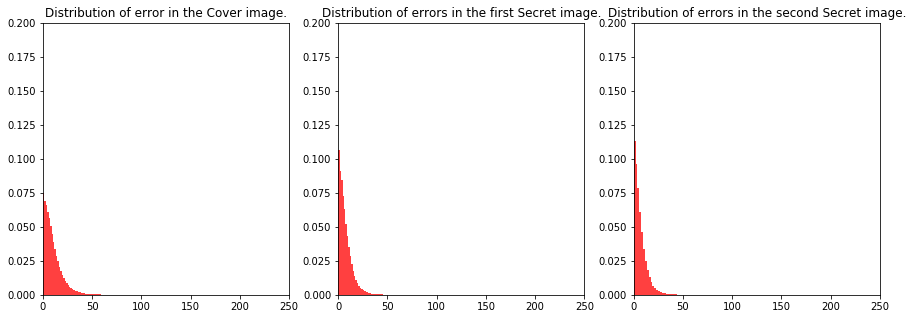

In [24]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S_1, diff_S_2, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

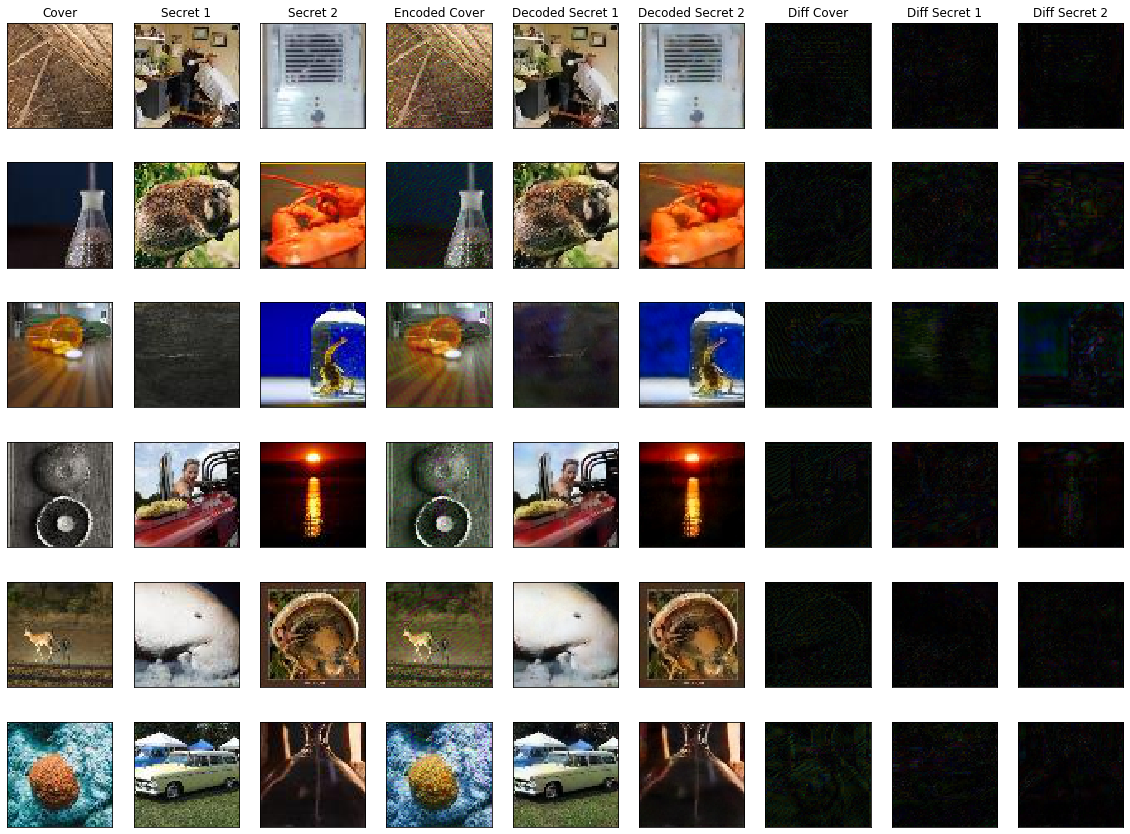

In [25]:
# Plot distribution of errors in cover and secret images.
plot_result(input_S, input_C, decoded_S_1, decoded_S_2,decoded_C,diff_S_1, diff_S_2 ,diff_C)

### Testing

In [26]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S_test, input_C_test])
decoded_S_1 = decoded[...,0:3]
decoded_S_2 = decoded[...,3:6]
decoded_C = decoded[...,6:9]

In [27]:
# Get absolute difference between the outputs and the expected values.
diff_S_1, diff_S_2, diff_C = np.abs(decoded_S_1 - input_S_test[...,0:3]),\
        np.abs(decoded_S_2 - input_S_test[...,3:6]), np.abs(decoded_C - input_C_test) 


In [28]:
# Print pixel-wise average errors in a 256 scale.
S_1_error, S_2_error, C_error = pixel_errors(input_S_test[...,0:3], input_S_test[...,3:6], input_C_test, decoded_S_1, decoded_S_2, decoded_C)

# S_1_error, S_2_error, C_error = pixel_errors(input_S_1, input_S_2, input_C, decoded_S_1, decoded_S_2, decoded_C)

print ("S 1 error per pixel [0, 255]:", S_1_error)
print ("S 2 error per pixel [0, 255]:", S_2_error)
print ("C error per pixel [0, 255]:", C_error)

S 1 error per pixel [0, 255]: 9.477316
S 2 error per pixel [0, 255]: 8.308391
C error per pixel [0, 255]: 11.886969


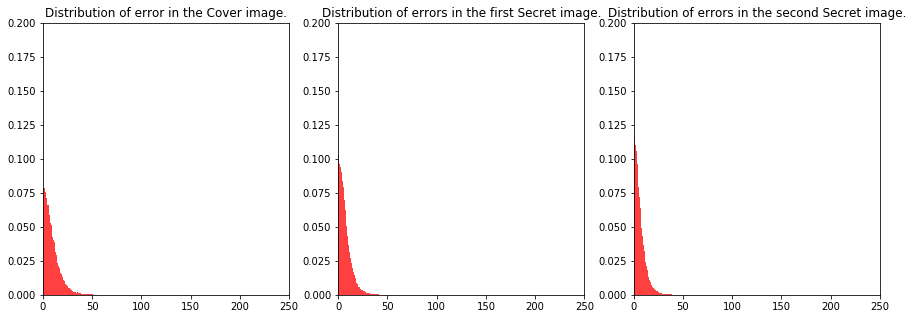

In [29]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S_1, diff_S_2, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

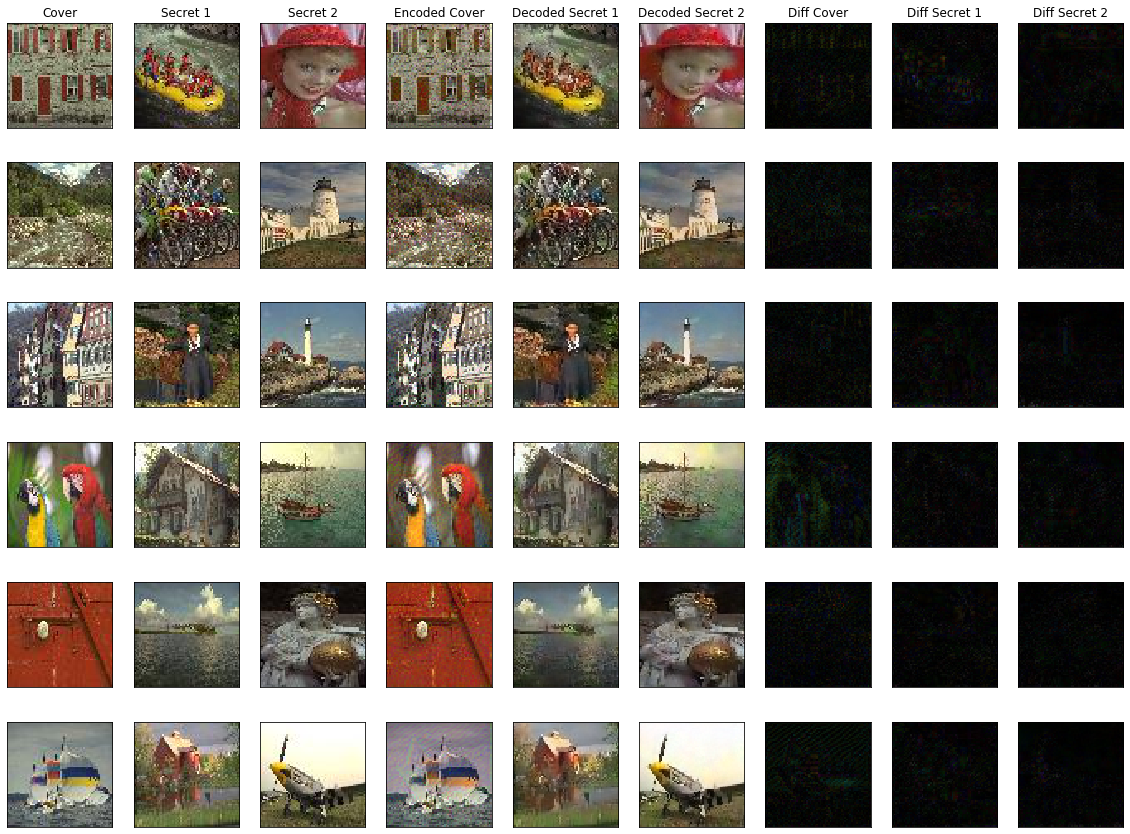

In [30]:
# Plot distribution of errors in cover and secret images.
plot_result(input_S_test, input_C_test, decoded_S_1, decoded_S_2, decoded_C,diff_S_1, diff_S_2 ,diff_C)